In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os

In [2]:
df = pd.read_excel(r'M:/Risk Management/DW/Scorecard/TUX_Scores/Oct2024_FormattedSampleData_Scoring_DaveS_UpdatedSegmentation.xlsx')

In [4]:
# drop unnecessary columns
df = df.drop(['ErrorMessage', 'SourceFileName'], axis=1)

In [5]:
# extract debtor id from id column
df['BIGDEBTORID'] = df['id'].astype(str).str[7:15]

In [6]:
# create bitprimary column
df['bitPrimary'] = df['id'].astype(str).str[-1]

In [7]:
# Weighting 60/40 towards credit
df['AvgEQScore60_40'] = (0.60 * df['CreditEqualizedScore']) + (0.40 * df['CapacityEqualizedScore'])

In [8]:
# Set 60/40 scoring column as int
df['AvgEQScore60_40'] = df['AvgEQScore60_40'].astype(int)

In [10]:
# Pivot showing number of debtor/codebtors for each score card
bitPrimary = pd.pivot_table(df, 
                           values='AccountId',
                           index='Scorecard Name',
                           columns='bitPrimary',
                           aggfunc='count',
                           fill_value=0
                           )
bitPrimary

bitPrimary,0,1
Scorecard Name,,
TUX_OpenBK,306,2554
TUX_ThickClean,936,6696
TUX_ThickDirty,2837,16202
TUX_Thin,3028,12337


In [11]:
# Pivot showing the avg TUX credit score for the bitPrimary pivot table
AvgCrScore_DebtorType = pd.pivot_table(df, 
                                    values='CreditEqualizedScore',
                                    index='Scorecard Name',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCrScore_DebtorType = AvgCrScore_DebtorType.astype(int)

AvgCrScore_DebtorType

bitPrimary,0,1
Scorecard Name,,
TUX_OpenBK,684,668
TUX_ThickClean,722,730
TUX_ThickDirty,646,646
TUX_Thin,625,622


In [12]:
# Pivot showing the avg capacity score for the bitPrimary pivot table
AvgCapScore_DebtorType = pd.pivot_table(df, 
                                    values='CapacityEqualizedScore',
                                    index='Scorecard Name',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCapScore_DebtorType = AvgCapScore_DebtorType.astype(int)

AvgCapScore_DebtorType

bitPrimary,0,1
Scorecard Name,,
TUX_OpenBK,722,716
TUX_ThickClean,740,715
TUX_ThickDirty,738,720
TUX_Thin,776,749


In [13]:
# Pivot showing the avg eq score for the bitPrimary pivot table
AvgEQScore_DebtorType = pd.pivot_table(df, 
                                    values='AverageEqualizedScore',
                                    index='Scorecard Name',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgEQScore_DebtorType = AvgEQScore_DebtorType.astype(int)

AvgEQScore_DebtorType

bitPrimary,0,1
Scorecard Name,,
TUX_OpenBK,703,692
TUX_ThickClean,731,722
TUX_ThickDirty,692,683
TUX_Thin,700,685


In [14]:
# Pivot showing the avg 60/40 eq score for the bitPrimary pivot table
Avg6040EQScore_DebtorType = pd.pivot_table(df, 
                                    values='AvgEQScore60_40',
                                    index='Scorecard Name',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
Avg6040EQScore_DebtorType = Avg6040EQScore_DebtorType.astype(int)

Avg6040EQScore_DebtorType

bitPrimary,0,1
Scorecard Name,,
TUX_OpenBK,699,687
TUX_ThickClean,729,723
TUX_ThickDirty,682,675
TUX_Thin,685,672


In [16]:
# Table count and % apps with co-debtors when they are in a different SC than applicant
account_groups = df.groupby('AccountId')
multi_applicant_accounts = account_groups.filter(lambda x: len(x) > 1)

# Check if Scorecard is different for applicants
multi_applicant_accounts['Scorecard_diff'] = multi_applicant_accounts.groupby('AccountId')['Scorecard Name'].transform('nunique') > 1

# Count how many unique apps are in different scorecards
accounts_with_diff_segments = multi_applicant_accounts[multi_applicant_accounts['Scorecard_diff']]

# Count different scorecard combinations for those accounts
segment_counts = pd.pivot_table(accounts_with_diff_segments,
                                values='AccountId', 
                                index='Scorecard Name', 
                                aggfunc='nunique')

# Calculate % of each scorecard in accounts with different segments
total_accounts_with_diff_segments = len(accounts_with_diff_segments['AccountId'].unique())
segment_counts['percentage'] = (segment_counts['AccountId'] / total_accounts_with_diff_segments) * 100

print(segment_counts)


                AccountId  percentage
Scorecard Name                       
TUX_OpenBK            147    4.565217
TUX_ThickClean       1475   45.807453
TUX_ThickDirty       2463   76.490683
TUX_Thin             2355   73.136646


In [17]:
# Check the distribution of 'bitPrimary' across full data set
print(df['bitPrimary'].value_counts())

bitPrimary
1    37789
0     7107
Name: count, dtype: int64


In [18]:
# ID multi-applicant accounts
coapp_accounts = df.groupby('AccountId').filter(lambda x: len(x) > 1)

# Check the number of multi-applicant accounts
print(f"Total multi-applicant accounts: {len(coapp_accounts['AccountId'].unique())}")

# If 'bitPrimary' is a string, convert it to integer
coapp_accounts['bitPrimary'] = coapp_accounts['bitPrimary'].astype(int)

# Then try separating primary applicants and coapplicants again
primary_applicants = coapp_accounts[coapp_accounts['bitPrimary'] == 1]
coapplicants = coapp_accounts[coapp_accounts['bitPrimary'] == 0]


# Separate primary applicants (bitPrimary == 1) and coapplicants (bitPrimary == 0)
primary_applicants = coapp_accounts[coapp_accounts['bitPrimary'] == 1]
coapplicants = coapp_accounts[coapp_accounts['bitPrimary'] == 0]

# Check the counts
print(f"Primary applicants count: {len(primary_applicants)}")
print(f"Coapplicants count: {len(coapplicants)}")

Total multi-applicant accounts: 6786
Primary applicants count: 6786
Coapplicants count: 6786


In [19]:
# Show generic distribution % of co-applicants across scorecards

# Merge primary applicants with coapplicants based on AccountId
merged_df = primary_applicants[['AccountId', 'Scorecard Name']].merge(
    coapplicants[['AccountId', 'Scorecard Name']], 
    on='AccountId', 
    suffixes=('_primary', '_coapplicant')
)

# Filter for cases where the applicants are in different scorecard segments
merged_df['different_scorecard'] = merged_df['Scorecard Name_primary'] != merged_df['Scorecard Name_coapplicant']

# Filter for cases where the applicants are in different scorecards
different_scorecard_df = merged_df[merged_df['different_scorecard']]

# Calculate the distribution of coapplicants scorecards
coapplicant_scorecard_distribution = different_scorecard_df['Scorecard Name_coapplicant'].value_counts(normalize=True) * 100

# Display the distribution as a percentage
print("Coapplicant Scorecard Distribution:")
print(coapplicant_scorecard_distribution)


Coapplicant Scorecard Distribution:
Scorecard Name_coapplicant
TUX_Thin          42.639752
TUX_ThickDirty    39.968944
TUX_ThickClean    16.242236
TUX_OpenBK         1.149068
Name: proportion, dtype: float64


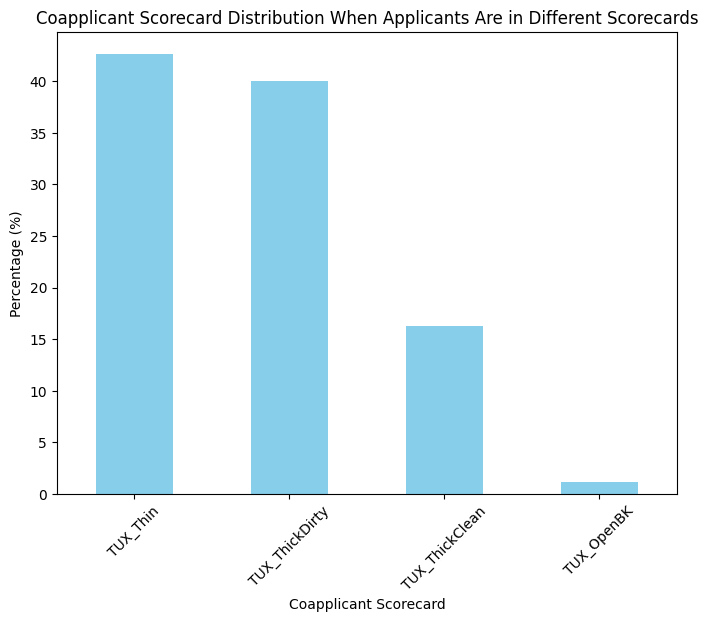

In [20]:
# Distribution plot of above calc
plt.figure(figsize=(8, 6))
coapplicant_scorecard_distribution.plot(kind='bar', color='skyblue')
plt.title('Coapplicant Scorecard Distribution When Applicants Are in Different Scorecards')
plt.xlabel('Coapplicant Scorecard')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()


In [21]:
# Create crosstab of Applicant Scorecard vs. Coapplicant Scorecard
scorecard_crosstab = pd.crosstab(
    different_scorecard_df['Scorecard Name_primary'],  # Rows: Applicant Scorecard
    different_scorecard_df['Scorecard Name_coapplicant'],  # Columns: Coapplicant Scorecard
    margins=True  # Adds a total row/column
)

# Normalize by row to show percentages instead of counts
scorecard_percentage_crosstab = pd.crosstab(
    different_scorecard_df['Scorecard Name_primary'],  
    different_scorecard_df['Scorecard Name_coapplicant'],  
    normalize='index' 
) * 100  

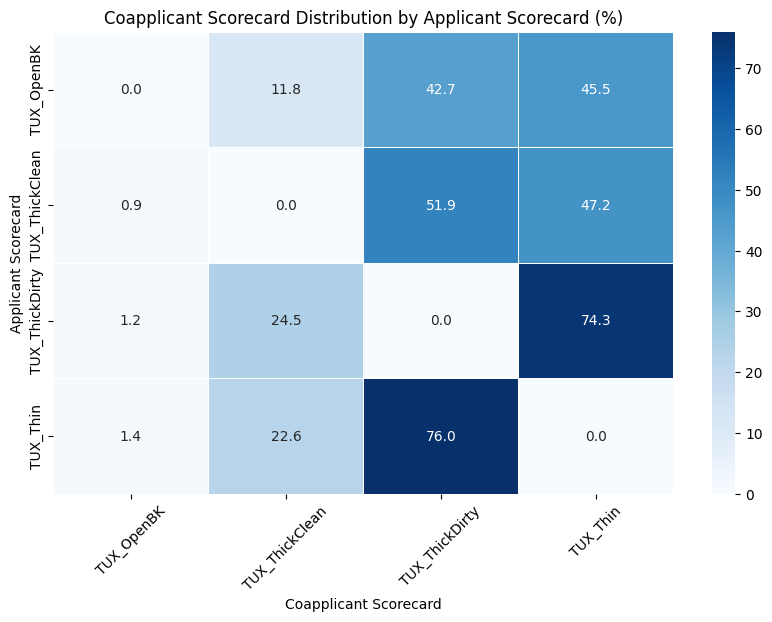

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(scorecard_percentage_crosstab, annot=True, fmt=".1f", cmap="Blues", linewidths=0.5)

plt.title("Coapplicant Scorecard Distribution by Applicant Scorecard (%)")
plt.xlabel("Coapplicant Scorecard")
plt.ylabel("Applicant Scorecard")
plt.xticks(rotation=45)
plt.show()


In [23]:
# Show % of apps with coapplicant where both debtors are on same scorecard
merged_df['same_scorecard'] = merged_df['Scorecard Name_primary'] == merged_df['Scorecard Name_coapplicant']

same_scorecard_df = merged_df[merged_df['same_scorecard']]

coapp_scorecard_distribution = same_scorecard_df['Scorecard Name_coapplicant'].value_counts(normalize=True) * 100

# Display the distribution as a percentage
print("Coapplicant Same Scorecard Distribution:")
print(coapp_scorecard_distribution)

Coapplicant Same Scorecard Distribution:
Scorecard Name_coapplicant
TUX_Thin          42.316321
TUX_ThickDirty    40.325294
TUX_ThickClean    10.039260
TUX_OpenBK         7.319125
Name: proportion, dtype: float64


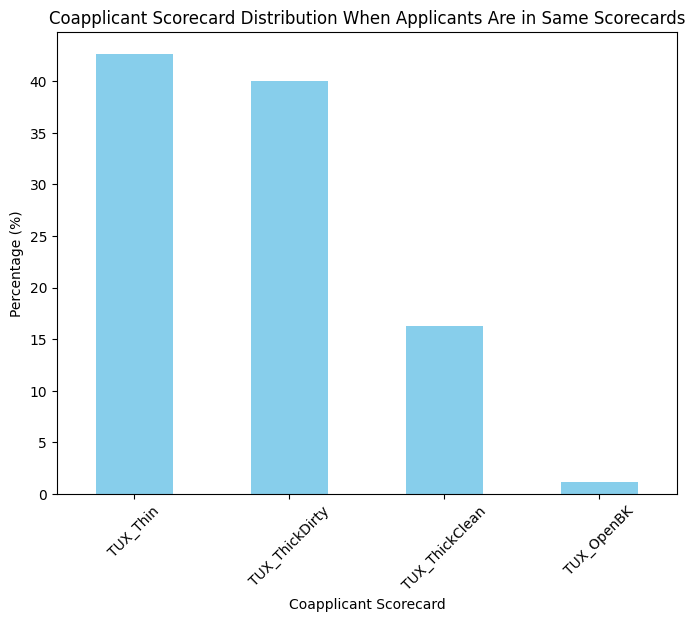

In [24]:
# Distribution plot of above calc
plt.figure(figsize=(8, 6))
coapplicant_scorecard_distribution.plot(kind='bar', color='skyblue')
plt.title('Coapplicant Scorecard Distribution When Applicants Are in Same Scorecards')
plt.xlabel('Coapplicant Scorecard')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()


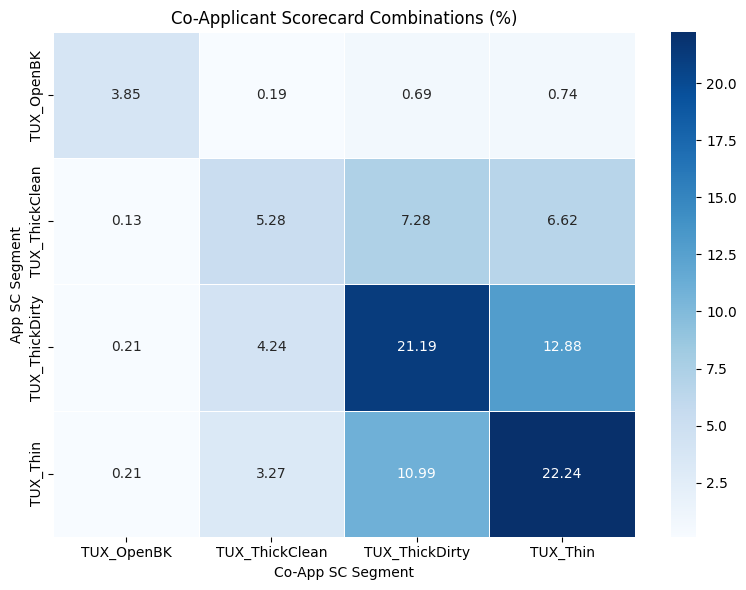

In [25]:
#cross tab of 2 debtor apps by scorecard segment %

def coapps_scorecard_ct(merged_df):
    crosstab = pd.crosstab(merged_df['Scorecard Name_primary'], merged_df['Scorecard Name_coapplicant'])
    crosstab_percent = crosstab / crosstab.sum().sum() * 100
    plt.figure(figsize=(8,6))
    sns.heatmap(crosstab_percent, annot=True, fmt='.2f', cmap="Blues", linewidths=0.5)
    plt.title("Co-Applicant Scorecard Combinations (%)")
    plt.xlabel("Co-App SC Segment")
    plt.ylabel("App SC Segment")
    plt.tight_layout()
    plt.show()

coapps_scorecard_ct(merged_df)

In [27]:
# df['Quintile'] = df.groupby('Scorecard Name')['CreditEqualizedScore'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))

# df['Quintile'] = df.groupby('Scorecard Name')['CapacityEqualizedScore'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))

# df['Quintile'] = df.groupby('Scorecard Name')['AverageEqualizedScore'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))

# df['Quintile'] = df.groupby('Scorecard Name')['AvgEQScore60_40'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))

In [28]:
# Quantile histogram function with equalized 20/20/20/20/20 distribution

def plot_segmented_distributions(df, score_col, segment_col, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store quantiles for each segment
    quantiles = {}
    for segment in df[segment_col].unique():
        quantiles[segment] = df[df[segment_col] == segment][score_col].quantile([0.2, 0.4, 0.6, 0.8])

    # Create a new column to store the quantile categories
    df['EQScore_Quantile'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(x, q=5, labels=["Q1 (0-20%)", "Q2 (20-40%)", "Q3 (40-60%)", "Q4 (60-80%)", "Q5 (80-100%)"], duplicates='drop'))

    unique_segments = df[segment_col].unique()

    for segment in unique_segments:
        # Get the quantile values for this segment
        quantile_values = quantiles[segment]
        
        # Create the plot
        plt.figure(figsize=(10, 5))
        sns.histplot(df[df[segment_col] == segment][score_col], bins=20, kde=True, color='royalblue')
        
        # Plot vertical dashed lines for quantiles
        plt.axvline(quantile_values[0.2], color='orange', linestyle='dashed', linewidth=2, label=f'Q1 (0-20%): {int(quantile_values[0.2])}')
        plt.axvline(quantile_values[0.4], color='yellow', linestyle='dashed', linewidth=2, label=f'Q2 (20-40%): {int(quantile_values[0.4])}')
        plt.axvline(quantile_values[0.6], color='green', linestyle='dashed', linewidth=2, label=f'Q3 (40-60%): {int(quantile_values[0.6])}')
        plt.axvline(quantile_values[0.8], color='blue', linestyle='dashed', linewidth=2, label=f'Q4 (60-80%): {int(quantile_values[0.8])}')
        
        # Plot the mean
        mean = df[df[segment_col] == segment][score_col].mean()
        plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean (μ): {int(mean)}')
        
        # Title and labels
        plt.title(f'Distribution of {score_col} for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Add legend
        plt.legend(loc='upper right')
        
        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_distribution.png')
        plt.savefig(file_path)  # Save the plot as a PNG image

        plt.show()
        plt.close()

In [29]:
# plot_segmented_distributions(df, 'CreditEqualizedScore', 'Scorecard Name')

In [30]:
# plot_segmented_distributions(df, 'CapacityEqualizedScore', 'Scorecard Name')

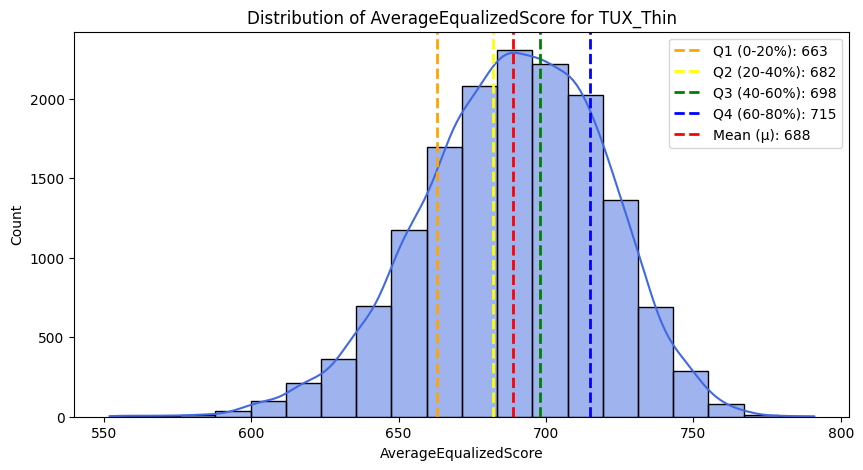

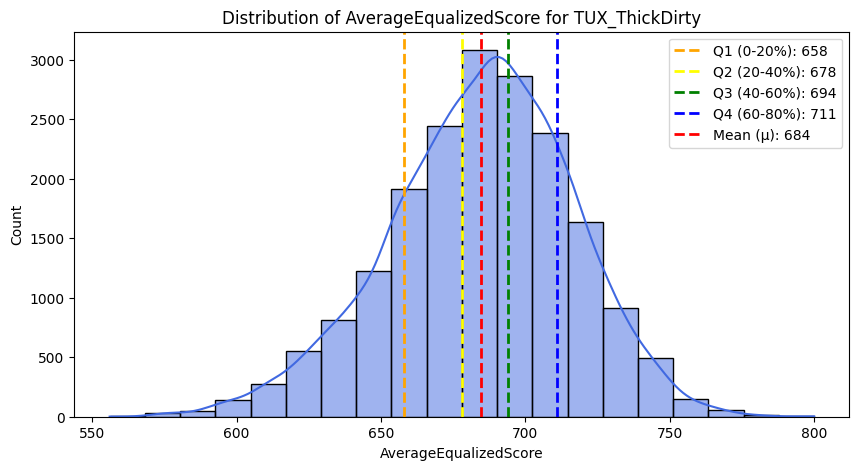

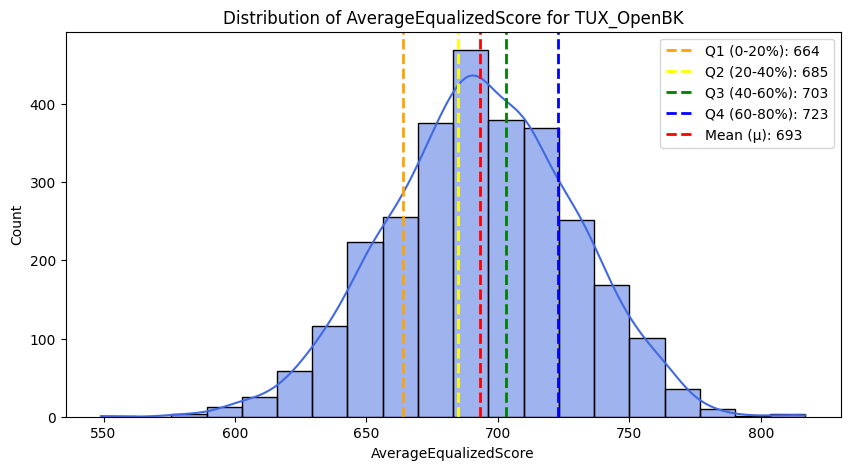

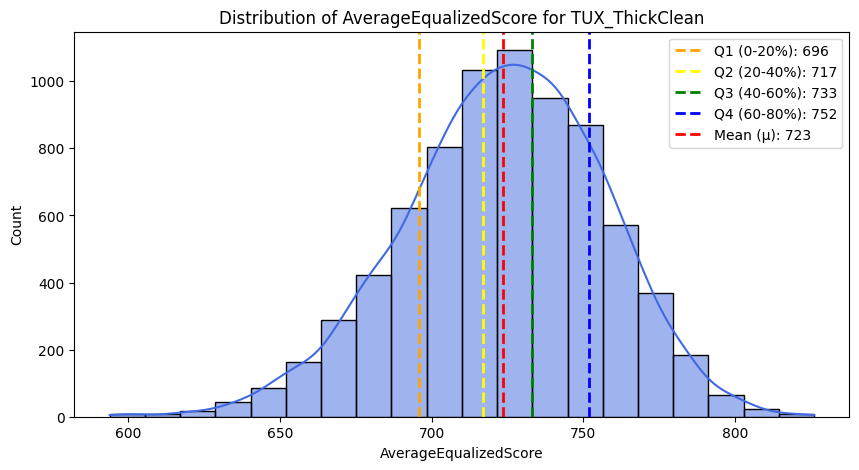

In [31]:
# showing initial distributions of equalized score averaged 50/50 credit/capacity

output_dir = r'M:/Risk Management/DW/Scorecard/TUX_Scores/Images/AVG_Equalized_Score_Graphs/'

plot_segmented_distributions(df, 'AverageEqualizedScore', 'Scorecard Name', output_dir)

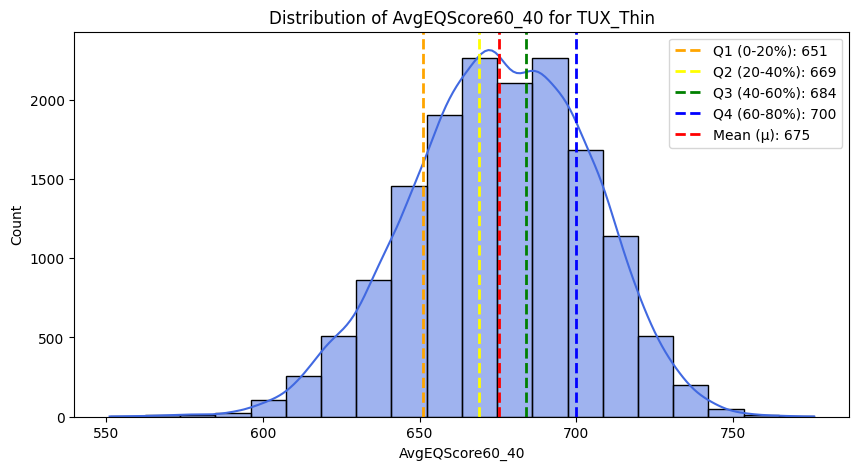

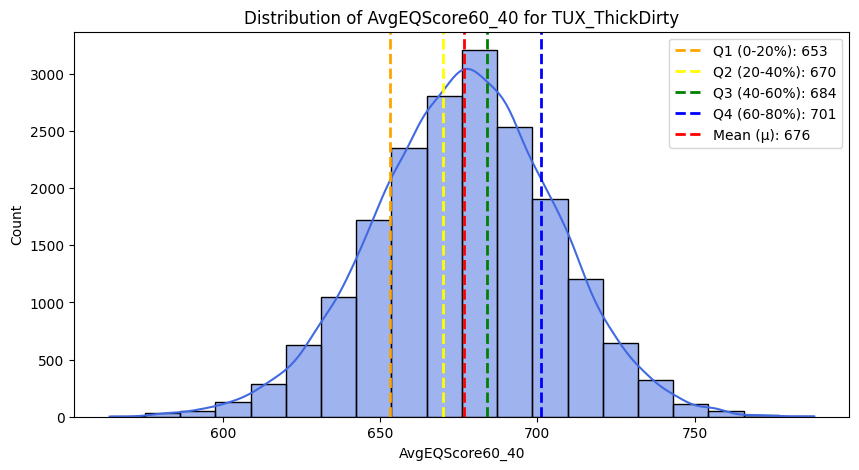

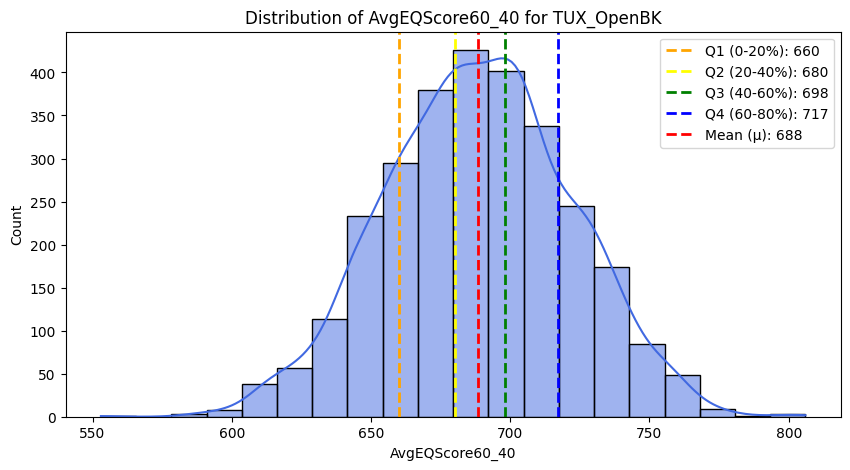

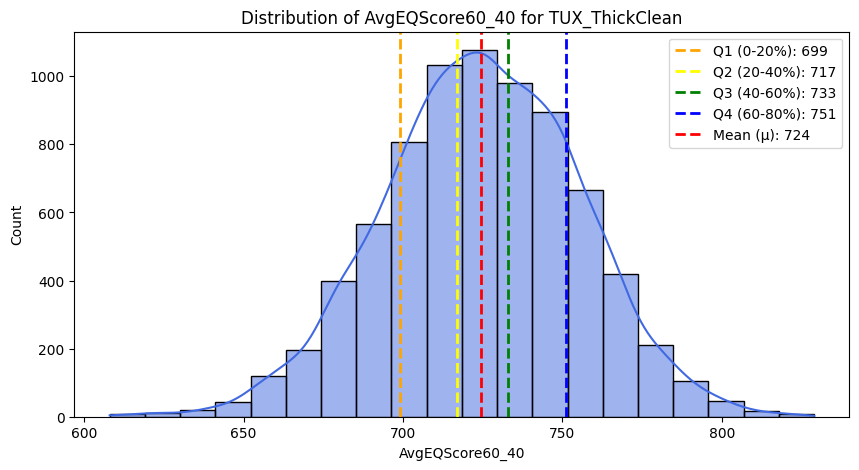

In [32]:
# showing scores from EQ60/40 weighted scoring

output_dir = r'M:/Risk Management/DW/Scorecard/TUX_Scores/Images/Weighted_6040_Score_Graphs/'

plot_segmented_distributions(df, 'AvgEQScore60_40', 'Scorecard Name', output_dir)

In [33]:
# standard deviation histogram function

def plot_std_histograms(df, score_col, segment_col, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    unique_segments = df[segment_col].unique()
    
    for segment in unique_segments:
        subset = df[df[segment_col] == segment]
        mean = subset[score_col].mean()
        std = subset[score_col].std()
        
        # Calculate standard deviation boundaries and convert to integer
        minus_1_std = int(mean - std)
        plus_1_std = int(mean + std)
        minus_2_std = int(mean - 2 * std)
        plus_2_std = int(mean + 2 * std)
        
        # Define the number of bins manually to control x-axis
        bin_width = (subset[score_col].max() - subset[score_col].min()) / 20
        bins = int((subset[score_col].max() - subset[score_col].min()) / bin_width)

        # Create a new figure
        plt.figure(figsize=(8, 5))
        
        # Plot the histogram with KDE
        sns.histplot(subset[score_col], bins=bins, kde=True, color='royalblue', alpha=0.6)
        
        # Plot mean and standard deviation lines
        line_1 = plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
        line_minus_1_std = plt.axvline(minus_1_std, color='orange', linestyle='dashed', linewidth=2)
        line_plus_1_std = plt.axvline(plus_1_std, color='orange', linestyle='dashed', linewidth=2)
        line_minus_2_std = plt.axvline(minus_2_std, color='green', linestyle='dashed', linewidth=2)
        line_plus_2_std = plt.axvline(plus_2_std, color='green', linestyle='dashed', linewidth=2)

        # Add the lines and their corresponding values in the legend
        plt.legend(
            handles=[line_1, line_plus_1_std, line_minus_1_std, line_plus_2_std, line_minus_2_std],
            labels=[f'Mean (μ): {int(mean)}', f'+1σ: {plus_1_std}', f'-1σ: {minus_1_std}', f'+2σ: {plus_2_std}', f'-2σ: {minus_2_std}'],
            loc='upper right'
        )
        
        # Title and labels
        plt.title(f'Score Distribution for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_std_distribution.png')
        plt.savefig(file_path) 

        plt.show()
        plt.close()

In [34]:
# plot_std_histograms(df, 'CreditEqualizedScore', 'Scorecard Name')

In [35]:
# plot_std_histograms(df, 'CapacityEqualizedScore', 'Scorecard Name')

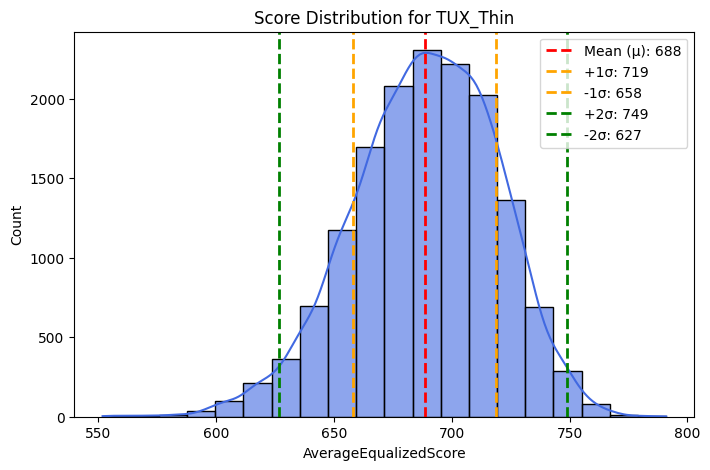

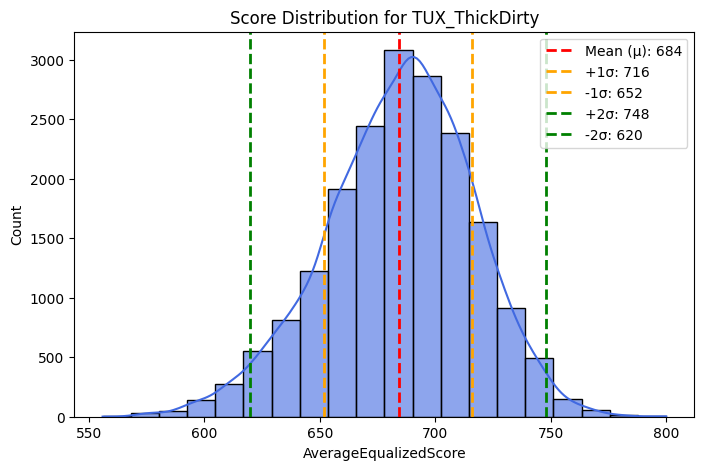

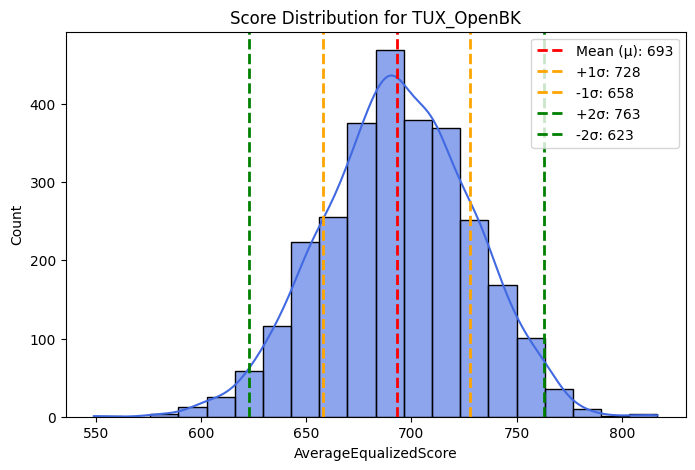

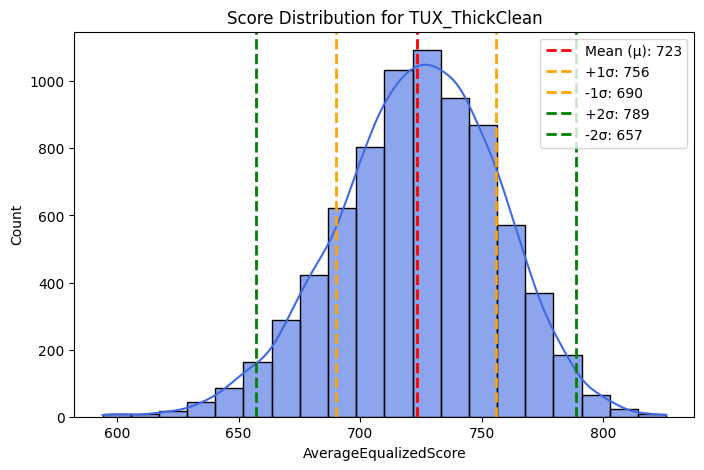

In [36]:
# st. dev histograms on averaged eq score
output_dir = r'M:/Risk Management/DW/Scorecard/TUX_Scores/Images/AVG_Equalized_Score_Graphs/'

plot_std_histograms(df, 'AverageEqualizedScore', 'Scorecard Name', output_dir)

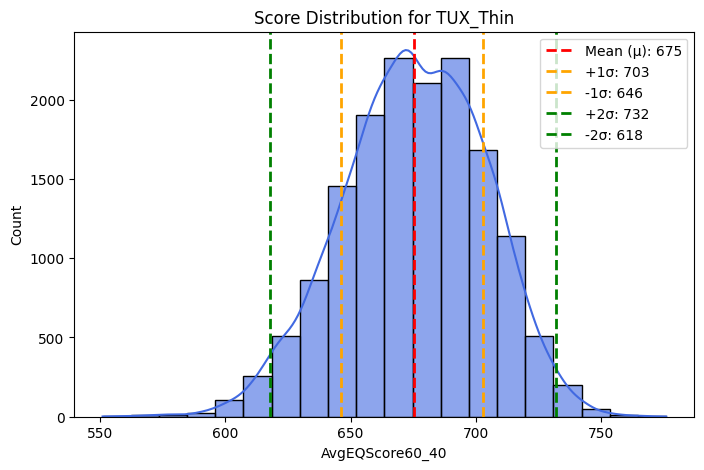

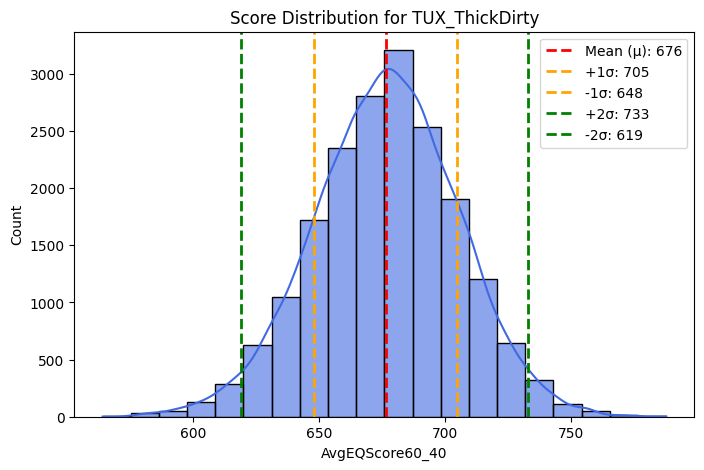

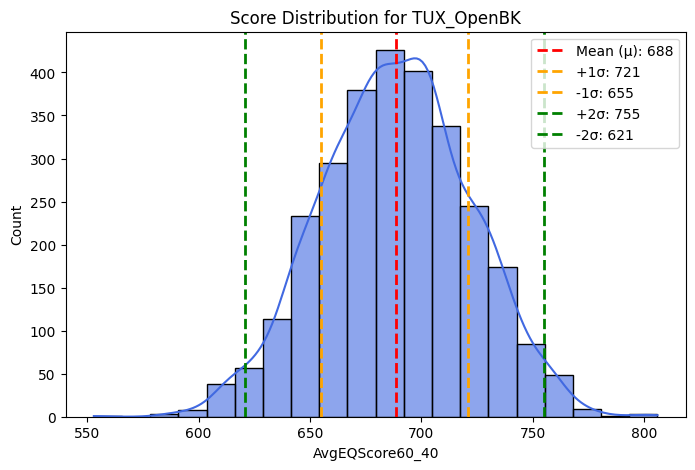

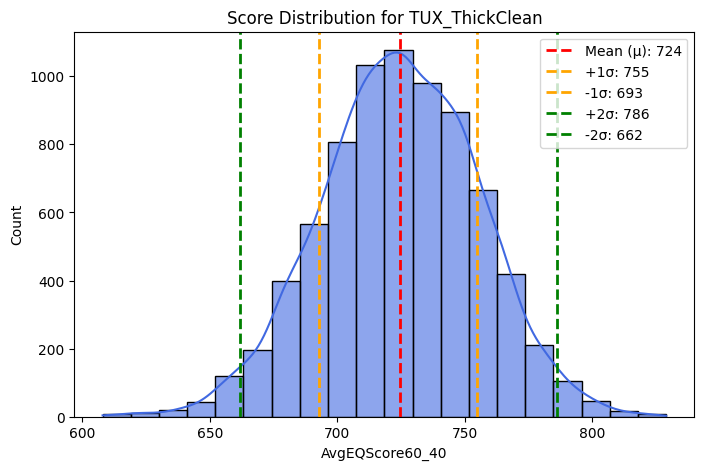

In [37]:
# st dev. histograms on eq60/40 score
output_dir = r'M:/Risk Management/DW/Scorecard/TUX_Scores/Images/Weighted_6040_Score_Graphs/'

plot_std_histograms(df, 'AvgEQScore60_40', 'Scorecard Name', output_dir)

In [38]:
# boxplot for scorecard segment scores
def plot_std_boxplot(df, score_col, segment_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=segment_col, y=score_col, hue=segment_col, palette='coolwarm', legend=False)
    plt.title('EQScore Distribution by SC Segment (Boxplot)')
    plt.xlabel(segment_col)
    plt.ylabel(score_col)
    plt.show()

In [39]:
# plot_std_boxplot(df, 'CreditEqualizedScore', 'Scorecard Name')

In [40]:
# plot_std_boxplot(df, 'CapacityEqualizedScore', 'Scorecard Name')

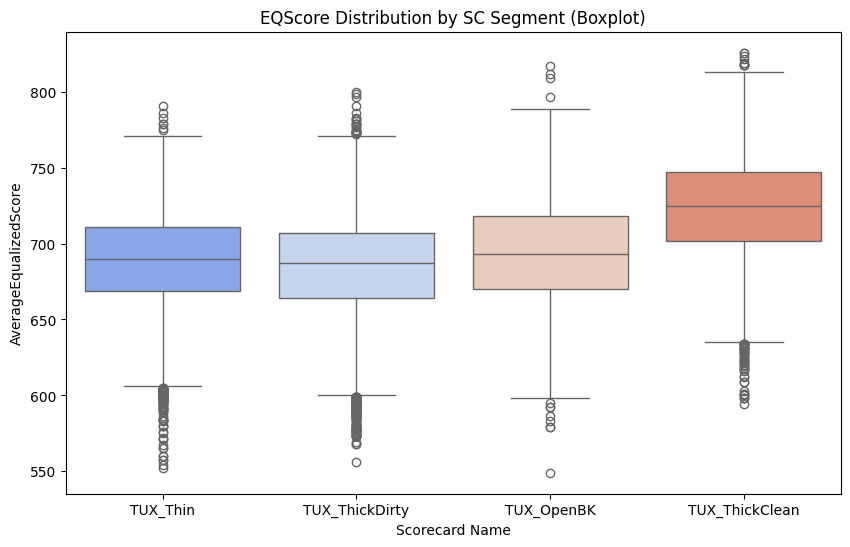

In [41]:
# equalized 50/50 score plotted
plot_std_boxplot(df, 'AverageEqualizedScore', 'Scorecard Name')

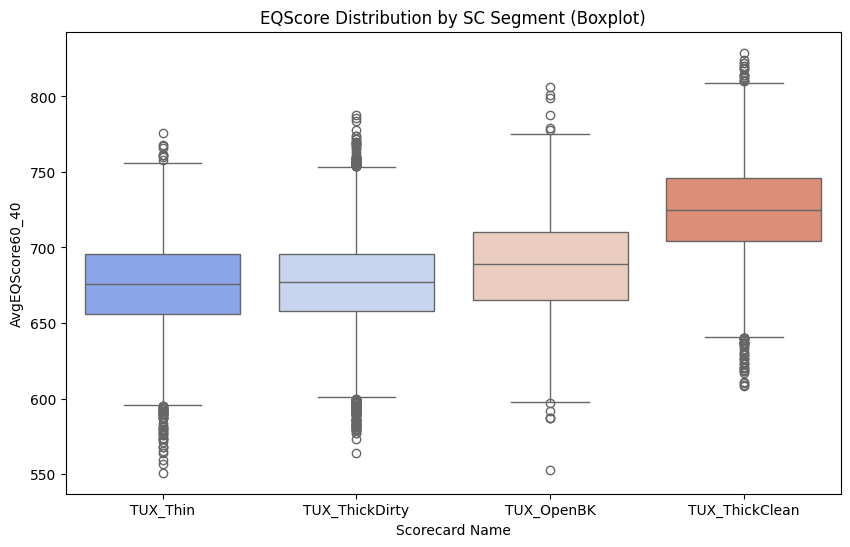

In [42]:
# eq60/40 score box plots

plot_std_boxplot(df, 'AvgEQScore60_40', 'Scorecard Name')

In [43]:
# distribition combined graphs - hist, boxplot, kde

def visualize_distributions(df, score_col, segment_col):
    segments = df[segment_col].unique()

    for segment in segments:
        subset = df[df[segment_col] == segment]
        mean_val = subset[score_col].mean()
        std_val = subset[score_col].std()

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Histogram with Std Dev Lines
        sns.histplot(subset[score_col], bins=20, kde=True, ax=axes[0], color="skyblue", edgecolor="black")
        axes[0].axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axes[0].axvline(mean_val + std_val, color='orange', linestyle='dashed', linewidth=2, label="+1 STD")
        axes[0].axvline(mean_val - std_val, color='orange', linestyle='dashed', linewidth=2, label="-1 STD")
        axes[0].axvline(mean_val + 2*std_val, color='green', linestyle='dashed', linewidth=2, label="+2 STD")
        axes[0].axvline(mean_val - 2*std_val, color='green', linestyle='dashed', linewidth=2, label="-2 STD")
        axes[0].set_title(f"Histogram of {score_col} - {segment}")
        axes[0].legend()

        # Boxplot to Show Spread & Outliers
        sns.boxplot(x=subset[score_col], ax=axes[1], color="lightblue")
        axes[1].set_title(f"Boxplot of {score_col} - {segment}")

        # KDE Density Plot - Comparing Percentile & Std Methods
        sns.kdeplot(subset[score_col], fill=True, ax=axes[2], color="blue", label="Density")
        axes[2].axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label="Mean")
        axes[2].axvline(mean_val + std_val, color='orange', linestyle='dashed', linewidth=2, label="+1 STD")
        axes[2].axvline(mean_val - std_val, color='orange', linestyle='dashed', linewidth=2, label="-1 STD")
        axes[2].set_title(f"KDE Plot - {segment}")
        axes[2].legend()

        plt.tight_layout()
        plt.show()




In [44]:
# # Function call
# score = 'CreditEqualizedScore'
# segment = 'Scorecard Name'
# visualize_distributions(df, score_col=score, segment_col=segment)

In [45]:
# # Function call
# score = 'CapacityEqualizedScore'
# segment = 'Scorecard Name'
# visualize_distributions(df, score_col=score, segment_col=segment)

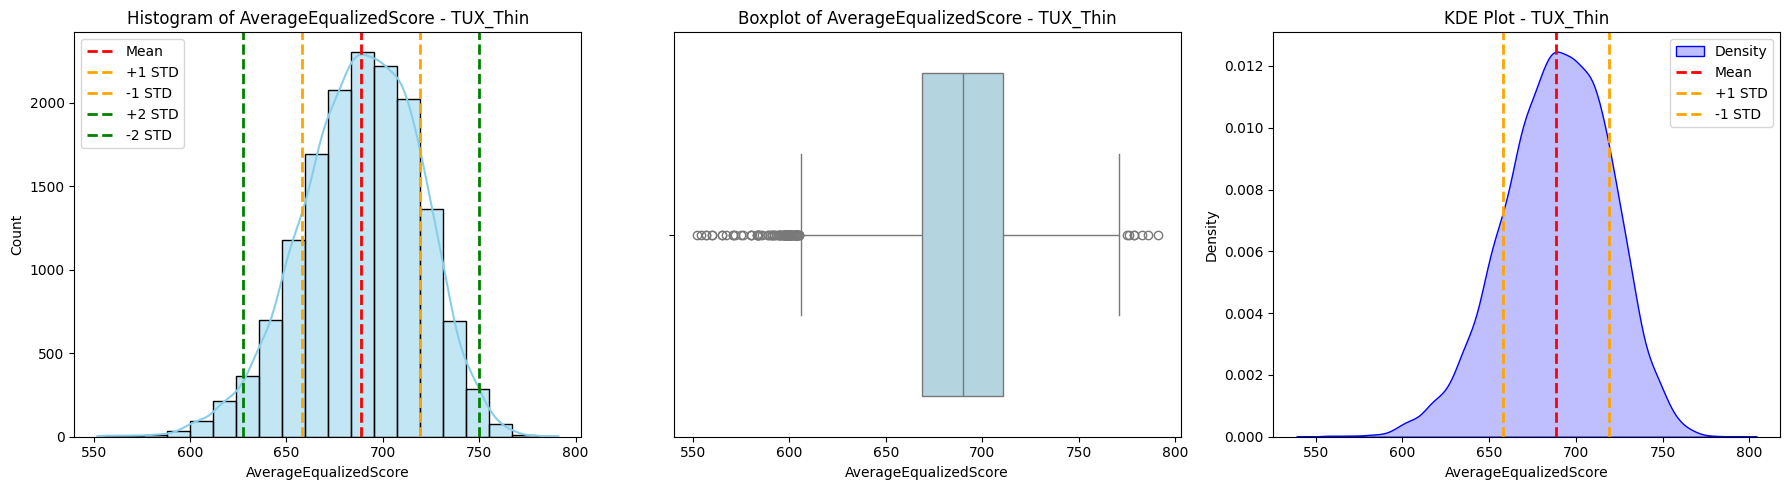

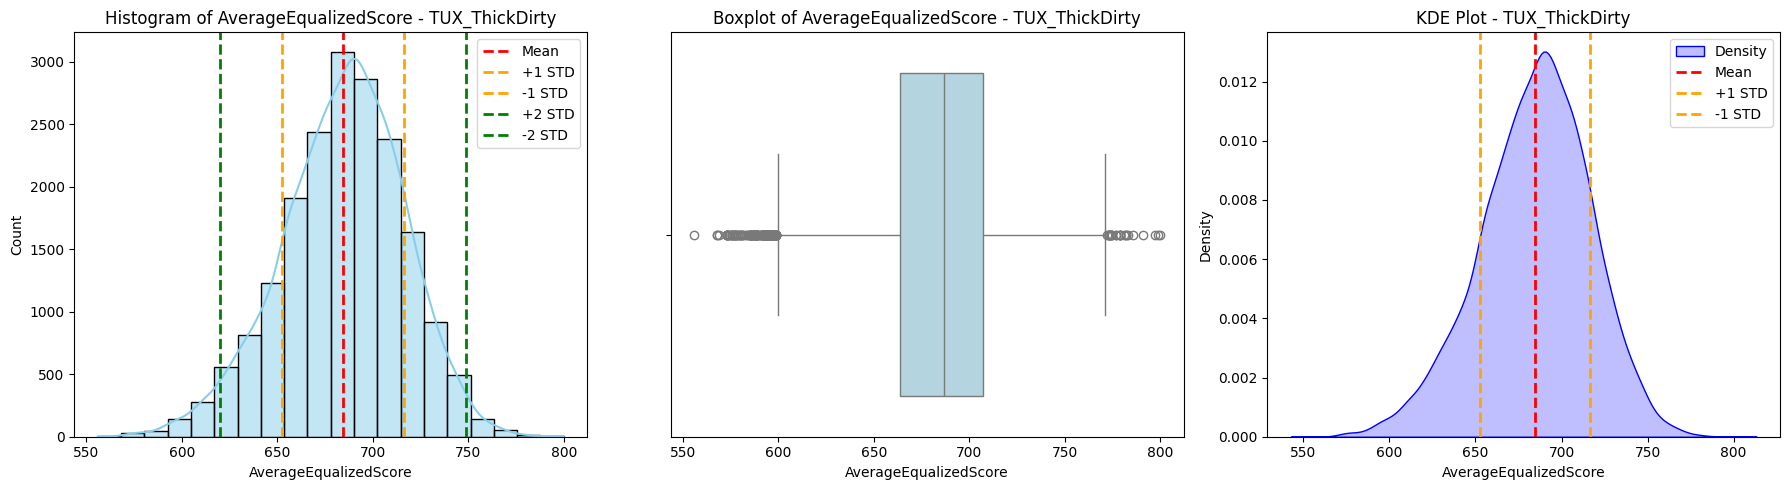

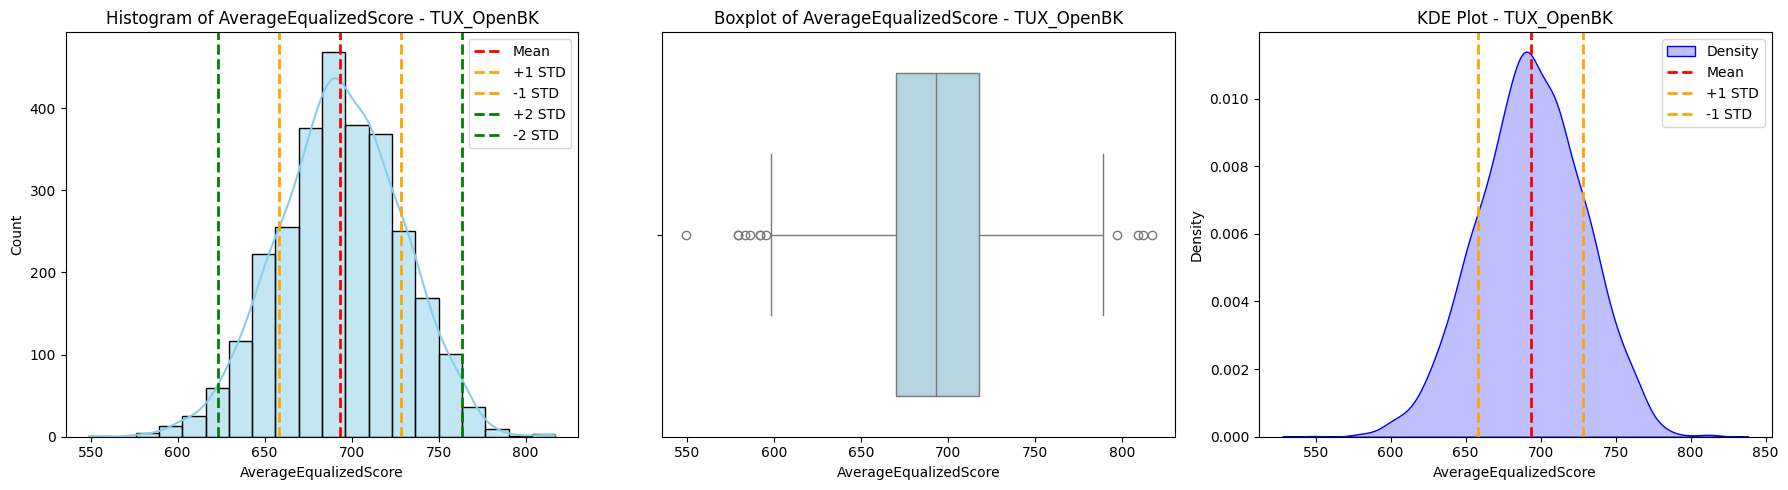

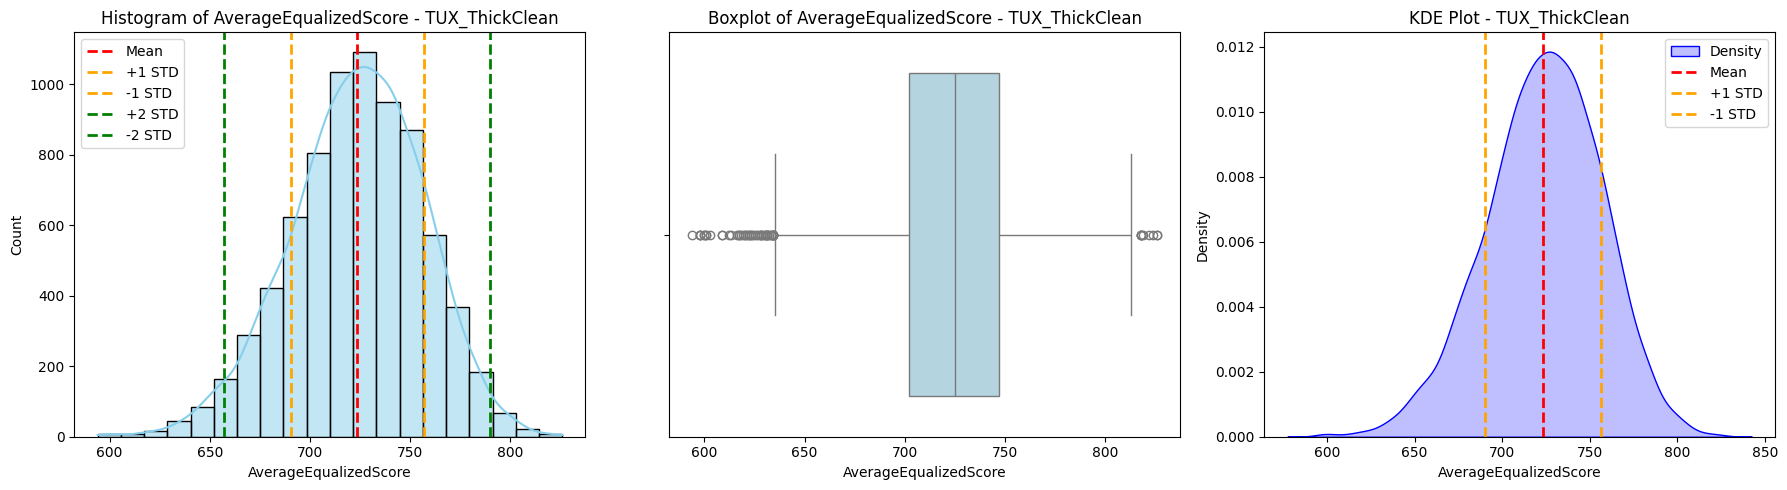

In [46]:
# Function call
score = 'AverageEqualizedScore'
segment = 'Scorecard Name'
visualize_distributions(df, score_col=score, segment_col=segment)

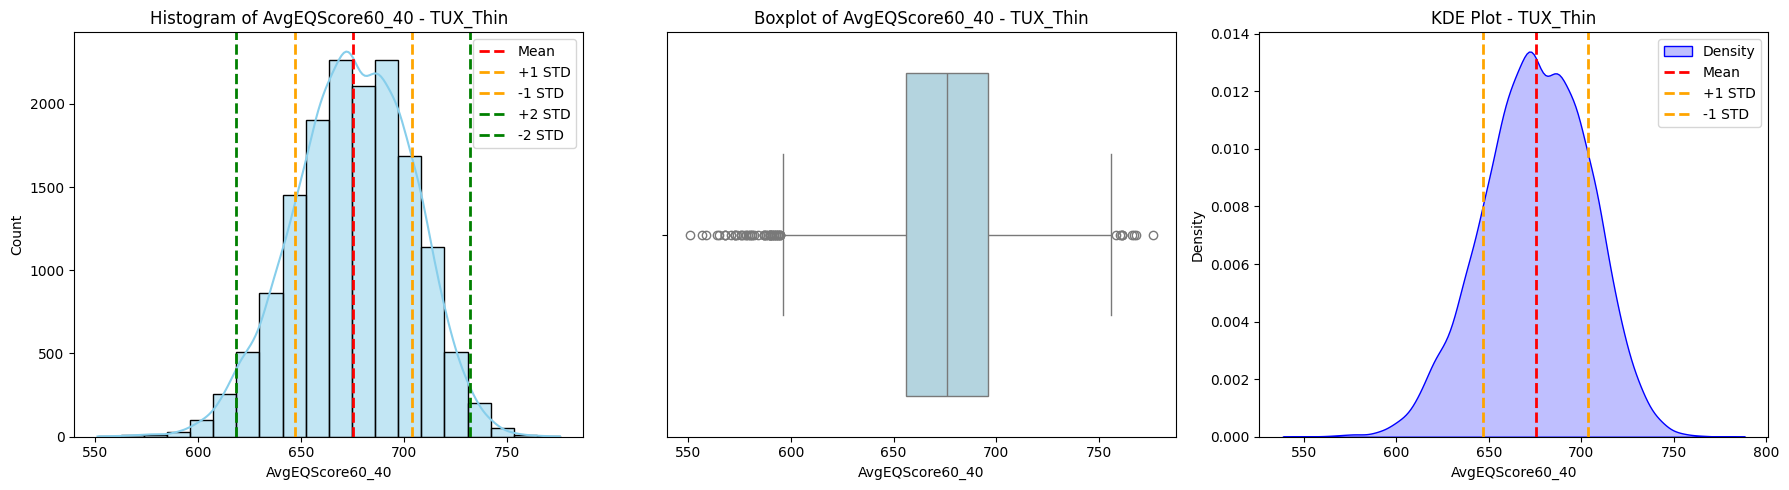

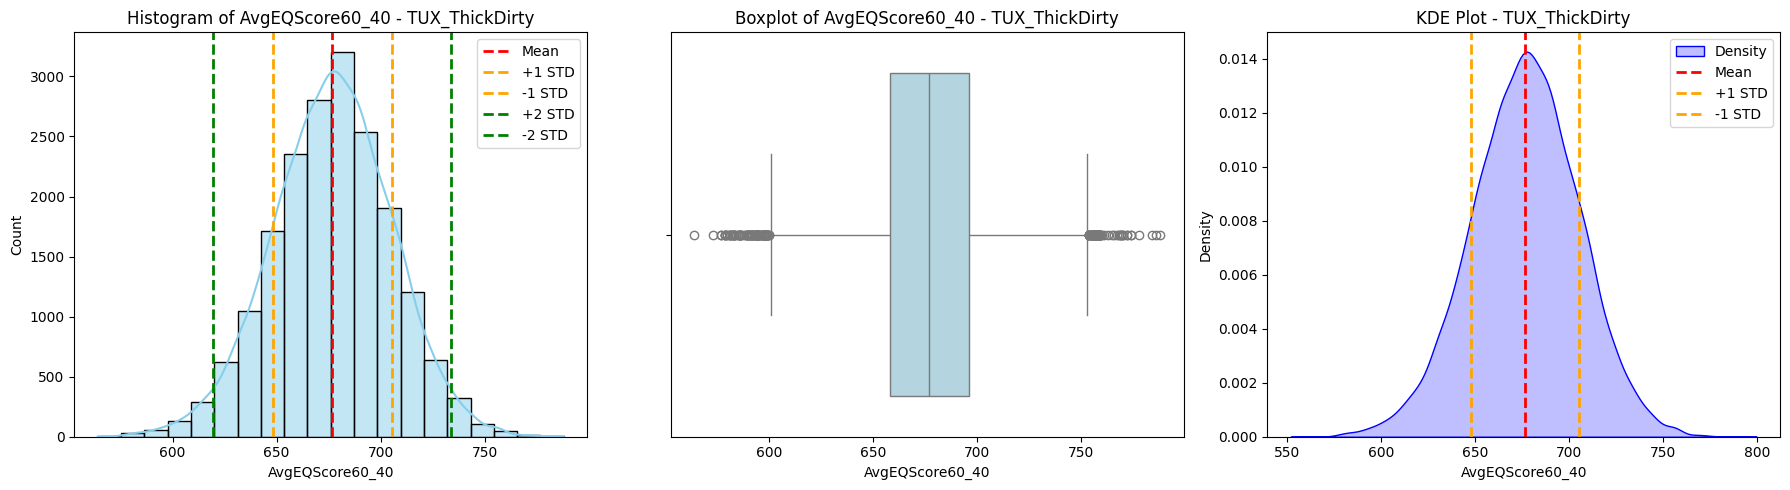

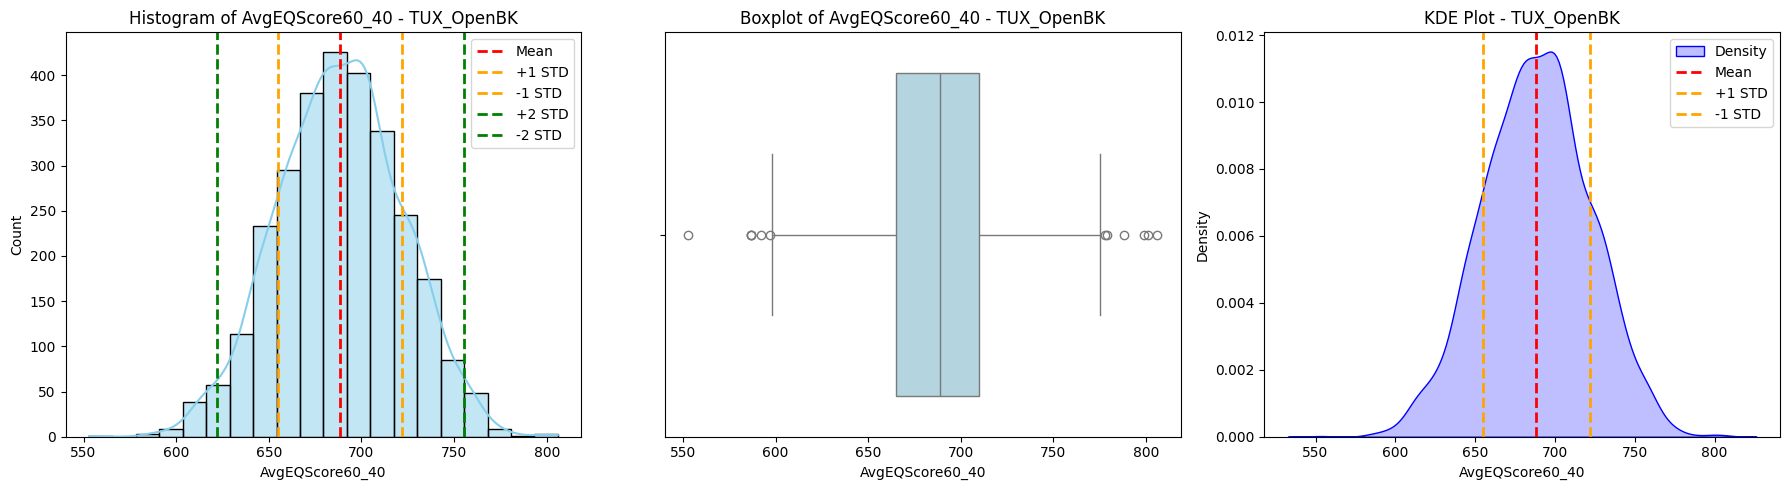

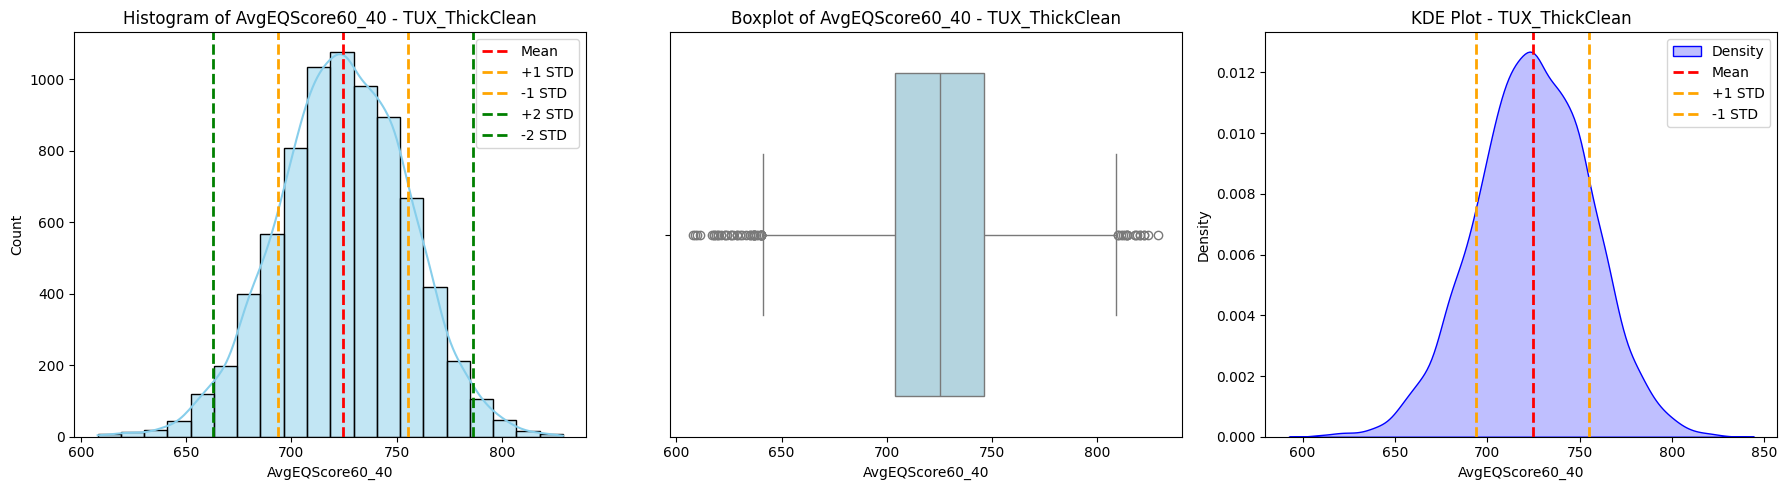

In [47]:
# Function call
score = 'AvgEQScore60_40'
segment = 'Scorecard Name'
visualize_distributions(df, score_col=score, segment_col=segment)

In [48]:
df.to_excel(r'M:/Risk Management/DW/Scorecard/TUX_Scores/Final_Validation_File_20250327.xlsx', index=False)

In [49]:
# distribution on debtor/codebtor scorecards and scores
# graph above using equally weighted average score
# compute 60/40 equalized score
# graph above using 60/40 split
# set thresholds for each segment


# check and see how we can combine scores and scorecards to account level score

In [ ]:
# Gen12 ecnls at 1.0 should be the apps hit by hardcuts. find and match to Gen13 apps on account id
# see what populations look like after this

# if we are taking the better of the 2 scorecards when 2 diff exist - 
# can we determine what the mix is on that?